We want to test the CombinedModel.py class, which is the most important script for the Emcee search.

In [1]:
#Control time packages
import time
import os

#General packages
import numpy as np
from My_Jampy import JAM
import matplotlib.pyplot as plt

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.constants import G, M_sun, c
import astropy.units as u

#Autolens Model packages
import autolens as al
import autolens.plot as aplt

#Combined Model package
import CombinedModel

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_4/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)           #DM component
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True) #PSF
x, y, vrms, erms              = np.loadtxt("Input/vrms_data.txt", unpack=True)#vrms data


### Input parameters
Defining same inputs used for Jampy simulation and Autolens simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder).

In [3]:
z_l     = 0.299                                                         #Lens Redshift
z_s    = 3.100                                                          #Source Redshift 
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, 0.35)                                  #anisotropy [ad]
inc     = 75                                                            #inclination [deg]
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                    (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)       #Deprojected axial ratio for inclination
qDM     = np.sqrt( qobs_dm[0]**2 - np.cos(inc_rad)**2)/np.sin(inc_rad)  #Deprojected DM axial ratio
kappa_s = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5                                                          #Scale radius of DM [arcsec]
ml      = 5.00                                                          #mass to light ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

pixsize = 0.2    #MUSE pixel size

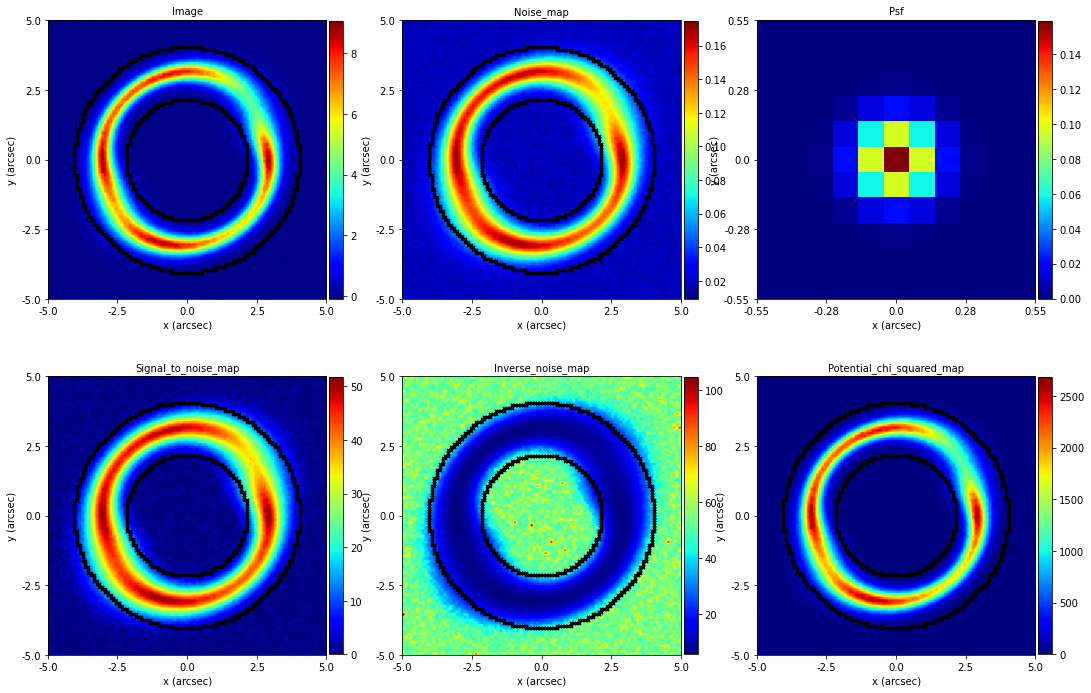

In [4]:
#Autolens Image
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask = al.Mask.circular_annular(centre=(0.0, 0.), inner_radius=2.1, outer_radius=4.1,
                              pixel_scales=imaging.pixel_scales, shape_2d=imaging.shape_2d) #Create a mask

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=False),                         #Plot
)

### Jampy Model

In [5]:
#Now we start our Jampy class
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
#Add DM component
Jam_model.DM_component(surf_dm=kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

### Autolens Model only MGE
Here we define the lens mass profile. This frist model uses the MGE eNFW decompostion.

In [6]:
#MGE mass profile

#Initializing
mass_profile_MGE = al.mp.MGE()


#Components
mass_profile_MGE.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile_MGE,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

## Initializing combined model
__Scalar Beta and Scalar ML__

In [7]:
#Just remembering, by default the model does not include dark matter.
model_MGE = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile_MGE,
                                 masked_imaging=masked_image, quiet=False)


model_MGE.mass_to_light(ml_kind='scalar')                                          #Setting scalar ML
model_MGE.beta(beta_kind='scalar')                                                 #Seting vector anisotropy
model_MGE.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Both")  #Setting Dark matter component

In [8]:
CombinedModel.boundary

{'qinc': [0.0501, 0.55],
 'beta': [-3, 3],
 'ml': [0.5, 15],
 'ml0': [0.5, 15],
 'delta': [0.1, 2],
 'lower': [0, 1],
 'kappa_s': [0, 2],
 'qDM': [0.1, 1],
 'log_mbh': [7, 11],
 'mag_shear': [0, 0.1],
 'phi_shear': [0, 179],
 'gamma': [0.8, 1.2]}

In [14]:
#Check Boundaries
model_MGE.print_boundary()

Your currently boundaries are:
qinc [0.0501, 0.55]
beta [-3, 3]
ml [0.5, 15]
ml0 [0.5, 15]
delta [0.1, 2]
lower [0, 1]
kappa_s [0, 2]
qDM [0.1, 1]
log_mbh [7, 11]
mag_shear [0, 0.1]
phi_shear [0, 179]
gamma [0.8, 1.2]


In [18]:
#Changing a boundary
key        = "delta"
new_delta  = [0.4, 0.6]
model_MGE.set_boundary(key, new_delta)
print("\n")
model_MGE.print_boundary()

Change delta limits to [0.4, 0.6], defaults are [0.4, 0.6]


Your currently boundaries are:
qinc [0.0501, 0.55]
beta [-3, 3]
ml [0.5, 15]
ml0 [0.5, 15]
delta [0.4, 0.6]
lower [0, 1]
kappa_s [0, 2]
qDM [0.1, 1]
log_mbh [7, 11]
mag_shear [0, 0.1]
phi_shear [0, 179]
gamma [0.8, 1.2]


   ### !!!!!!!   PAY CLOSE MUCH ATTENTION TO THE ORDER OF PARAMETERS.   !!!!!!!!

ParsDic {'ml': 5.0, 'beta': 0.35, 'qinc': 0.5024159164648028, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.8381983037452734, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.60
inc=75.0 beta_z=0.35 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 9.983e+12


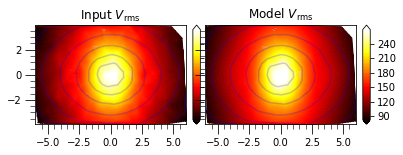

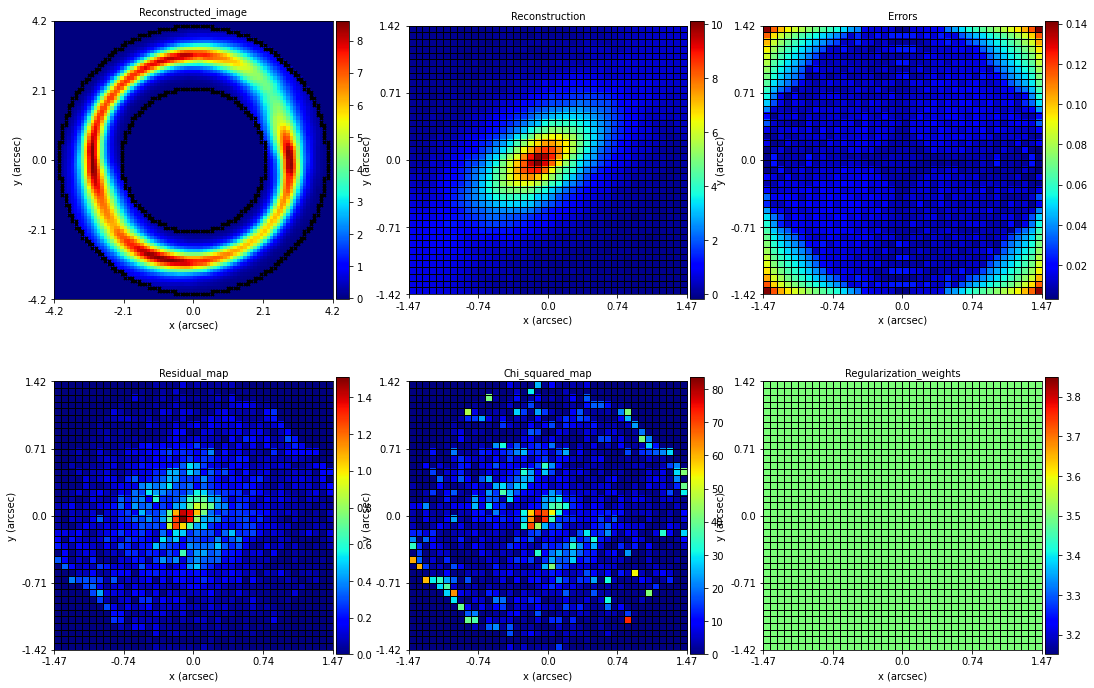

CPU times: user 7.62 s, sys: 160 ms, total: 7.78 s
Wall time: 6.2 s


-5076.9874045070155

In [37]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma 
ml_model     = np.array([ml])                      #mass to light ratio
beta_model   = np.array([beta[0]])  #anisotropy [ad]
p0           = np.append(ml_model, beta_model)

others = np.array([qinc, np.log10(mbh), kappa_s, qDM, 0.02, 88, 1.0])#Other parameters
p0     = np.append(p0, others)                        #All parameters

%time model_MGE(p0) 

## Initializing combined model
__Scalar Beta and ML Gradient__

In [48]:
model_MGE = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile_MGE,
                                 masked_imaging=masked_image, quiet=False)


model_MGE.mass_to_light(ml_kind='gradient')                                          #Setting scalar ML
model_MGE.beta(beta_kind='scalar')                                                 #Seting vector anisotropy
model_MGE.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Both")  #Setting Dark matter component

ParsDic {'ml': array([5.        , 4.42857143, 3.85714286, 3.28571429, 2.71428571,
       2.14285714, 1.57142857, 1.        ]), 'beta': 0.35, 'qinc': 0.5024159164648028, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.8381983037452734, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.59
inc=75.0 beta_z=0.35 M/L=1 BH=1.00e+09 chi2/DOF=2.08e+04
Total mass MGE: 9.75e+12


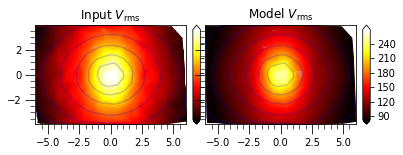

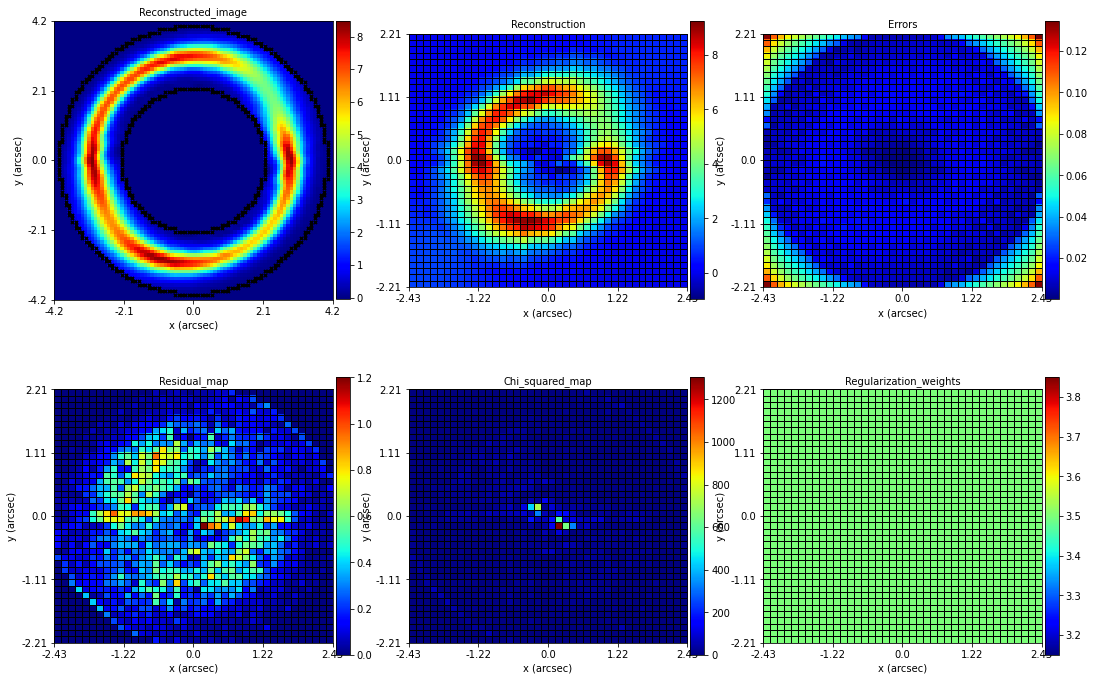

CPU times: user 7.13 s, sys: 136 ms, total: 7.27 s
Wall time: 5.72 s


-3132491.2482757624

In [50]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma 
ml_model     = np.linspace(ml, 1, surf_lum.size)                      #mass to light ratio
beta_model   = np.array([beta[0]])  #anisotropy [ad]
p0           = np.append(ml_model, beta_model)

others = np.array([qinc, np.log10(mbh), kappa_s, qDM, 0.02, 88, 1.0])#Other parameters
p0     = np.append(p0, others)                                       #All parameters

%time model_MGE(p0) 

## Initializing combined model
__Scalar Beta and ML Gaussian__

In [51]:
model_MGE = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile_MGE,
                                 masked_imaging=masked_image, quiet=False)


model_MGE.mass_to_light(ml_kind='gaussian')                                          #Setting scalar ML
model_MGE.beta(beta_kind='scalar')                                                 #Seting vector anisotropy
model_MGE.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Both")  #Setting Dark matter component

ParsDic {'ml0': 5.5, 'delta': 0.5, 'lower': 0.5, 'beta': 0.35, 'qinc': 0.5024159164648028, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.8381983037452734, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.59
inc=75.0 beta_z=0.35 M/L=1 BH=1.00e+09 chi2/DOF=21.6
Total mass MGE: 9.956e+12


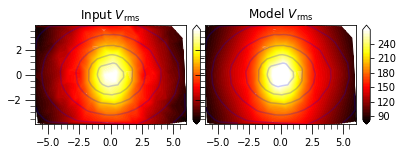

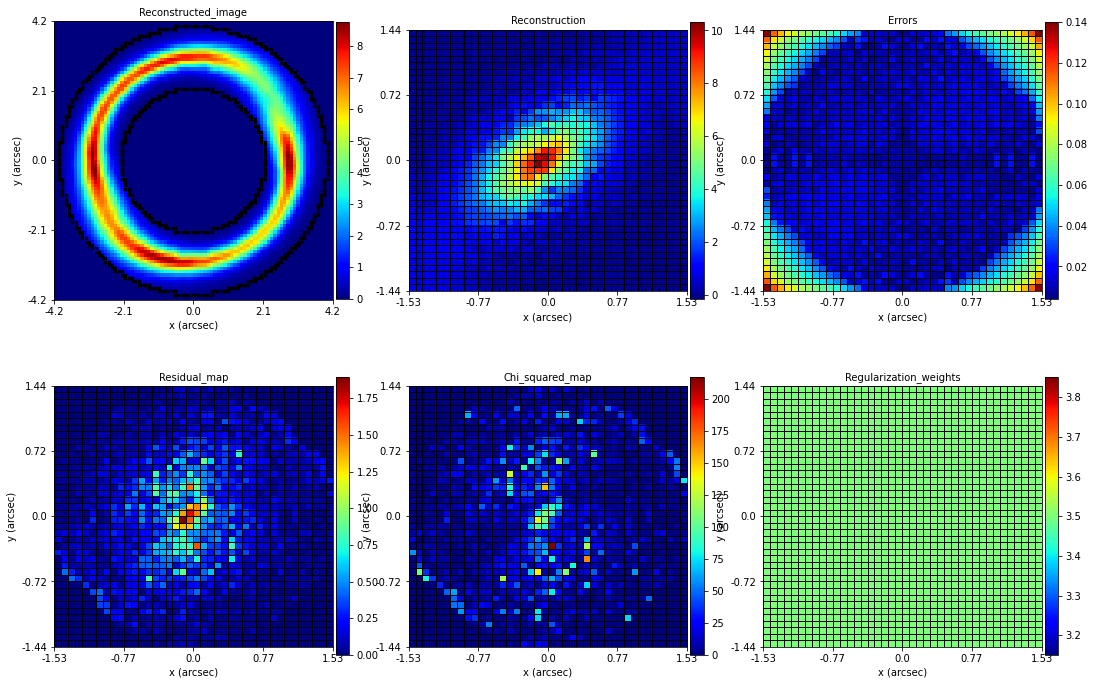

CPU times: user 7.3 s, sys: 144 ms, total: 7.45 s
Wall time: 5.91 s


-12016.779332202072

In [56]:
#In order: ML0, delta, lower, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma 
ml_model     = np.array([5.5, 0.5, 0.5])   #mass to light ratio
beta_model   = np.array([beta[0]])         #anisotropy [ad]
p0     = np.append(ml_model, beta_model)

others = np.array([qinc, np.log10(mbh), kappa_s, qDM, 0.02, 88, 1.0])#Other parameters
p0     = np.append(p0, others)                        #All parameters

%time model_MGE(p0)

## Initializing combined model
__Vector Beta and ML Gradient__

In [58]:
model_MGE = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile_MGE,
                                 masked_imaging=masked_image, quiet=False)


model_MGE.mass_to_light(ml_kind='gradient')                                          #Setting scalar ML
model_MGE.beta(beta_kind='vector')                                                 #Seting vector anisotropy
model_MGE.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Both")  #Setting Dark matter component

ParsDic {'ml': array([5.        , 4.85714286, 4.71428571, 4.57142857, 4.42857143,
       4.28571429, 4.14285714, 4.        ]), 'beta': array([0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35]), 'qinc': 0.5024159164648028, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.8381983037452734, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.60
inc=75.0 beta_z=0.35 M/L=1 BH=1.00e+09 chi2/DOF=1.11e+03
Total mass MGE: 9.925e+12


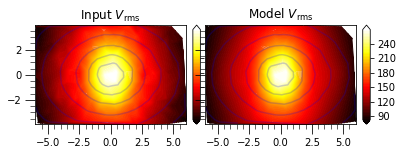

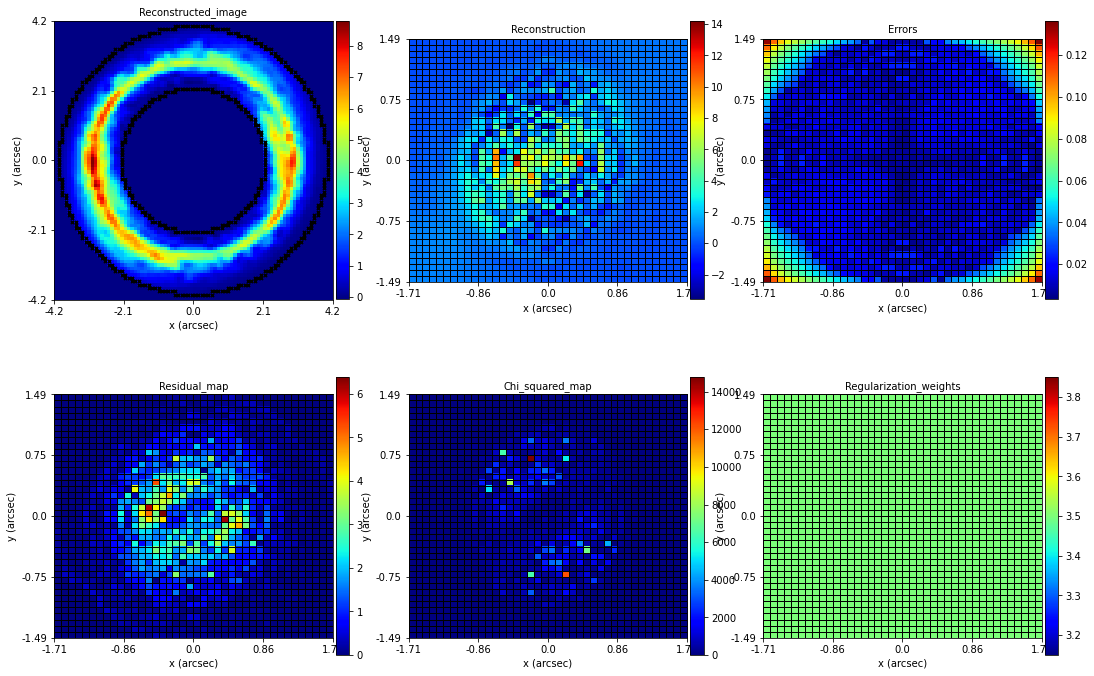

CPU times: user 7.12 s, sys: 144 ms, total: 7.26 s
Wall time: 5.72 s


-373152.22814766027

In [64]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma 
ml_model     = np.linspace(ml, 4, surf_lum.size)           #mass to light ratio
beta_model   = beta                                        #anisotropy [ad]
p0           = np.append(ml_model, beta_model)

others = np.array([qinc, np.log10(mbh), kappa_s, qDM, 0.02, 88, 1.0])#Other parameters
p0     = np.append(p0, others)                                       #All parameters

%time model_MGE(p0) 

### Autolens Model with Analytical profile
Here we define the lens mass profile. This model uses the MGE star component and an eNFW analytical component.

In [6]:
#MGE mass profile

#Initializing

mass_profile = al.mp.MGE()
ell_comps    = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW         = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s, elliptical_comps=ell_comps ,scale_radius=r_s) #Analytical eNFW profile


#Components
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh) #Do not include MGE DM component here

mass_profile.Analytic_Model(eNFW)  #Include Analytical NFW


#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

## Initializing combined model
__Scalar Beta and Scalar ML__

In [7]:
#Just remembering, by default the model does not include dark matter.
model_analytical = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile,
                                 masked_imaging=masked_image, quiet=False)


model_analytical.mass_to_light(ml_kind='scalar')                                          #Setting scalar ML
model_analytical.beta(beta_kind='scalar')                                                 #Seting vector anisotropy
model_analytical.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Dynamical") #Setting Dark matter component only in the Dynamical Model

   ### !!!!!!!   PAY CLOSE MUCH ATTENTION TO THE ORDER OF PARAMETERS.   !!!!!!!!

ParsDic {'ml': 5.0, 'beta': 0.35, 'qinc': 0.5024159164648028, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.8381983037452734, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.61
inc=75.0 beta_z=0.35 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 9.983e+12


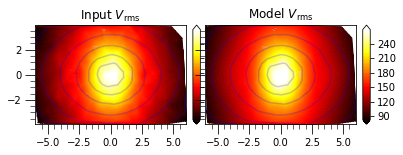

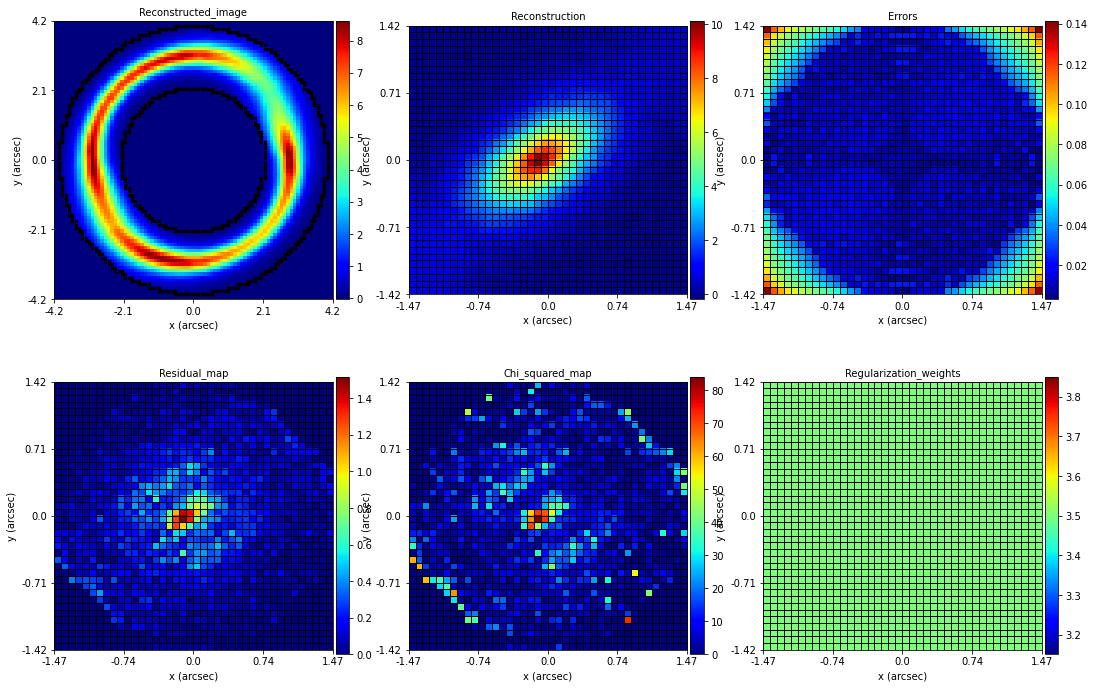

CPU times: user 10.3 s, sys: 158 ms, total: 10.4 s
Wall time: 8.67 s


-5074.747828426989

In [8]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma 
ml_model     = np.array([ml])                      #mass to light ratio
beta_model   = np.array([beta[0]])  #anisotropy [ad]
p0           = np.append(ml_model, beta_model)

others = np.array([qinc, np.log10(mbh), kappa_s, qDM, 0.02, 88, 1.0])#Other parameters
p0     = np.append(p0, others)                        #All parameters

%time model_analytical(p0) 

## Initializing combined model
__Scalar Beta and ML Gradient__

In [9]:
model_analytical = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile,
                                 masked_imaging=masked_image, quiet=False)


model_analytical.mass_to_light(ml_kind='gradient')                                          #Setting scalar ML
model_analytical.beta(beta_kind='scalar')                                                 #Seting vector anisotropy
model_analytical.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Dynamical")  #Setting Dark matter component

ParsDic {'ml': array([10.        ,  8.71428571,  7.42857143,  6.14285714,  4.85714286,
        3.57142857,  2.28571429,  1.        ]), 'beta': 0.35, 'qinc': 0.5024159164648028, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.8381983037452734, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.58
inc=75.0 beta_z=0.35 M/L=1 BH=1.00e+09 chi2/DOF=506
Total mass MGE: 9.894e+12


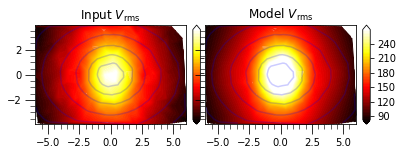

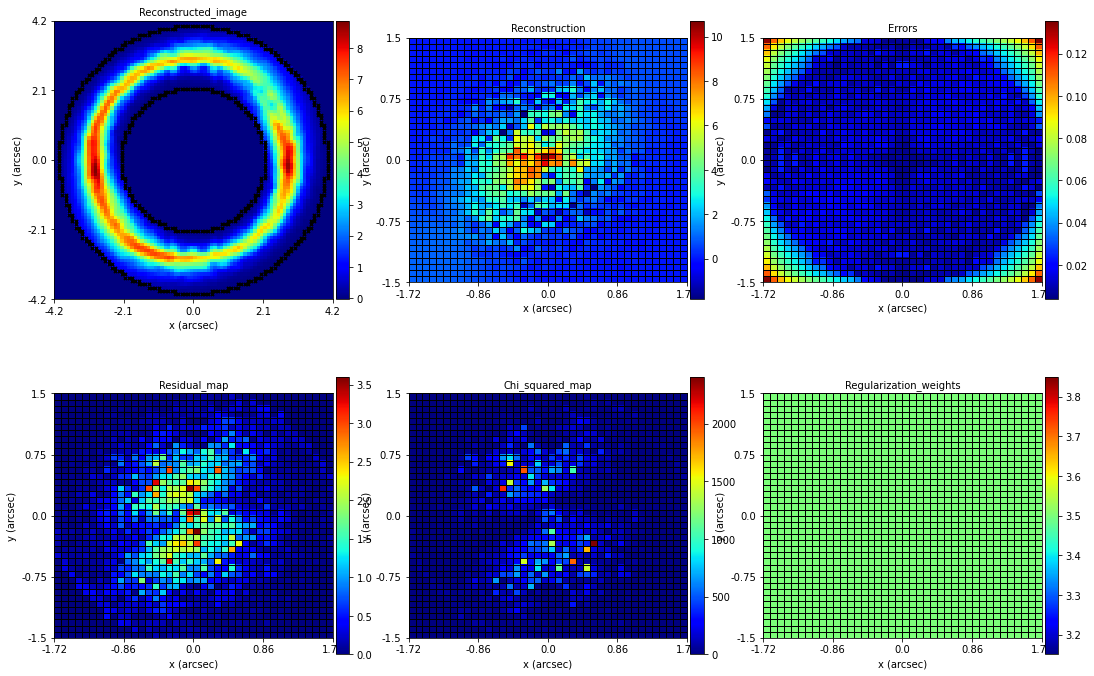

CPU times: user 6.68 s, sys: 219 ms, total: 6.89 s
Wall time: 5.1 s


-143800.60075687175

In [10]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma 
ml_model     = np.linspace(10, 1, surf_lum.size)                      #mass to light ratio
beta_model   = np.array([beta[0]])  #anisotropy [ad]
p0           = np.append(ml_model, beta_model)

others = np.array([qinc, np.log10(mbh), kappa_s, qDM, 0.02, 88, 1.0])#Other parameters
p0     = np.append(p0, others)                                       #All parameters

%time model_analytical(p0) 

In [11]:
model_analytical = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile,
                                 masked_imaging=masked_image, quiet=False)


model_analytical.mass_to_light(ml_kind='gradient')                                          #Setting scalar ML
model_analytical.beta(beta_kind='vector')                                                 #Seting vector anisotropy
model_analytical.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Dynamical")  #Setting Dark matter component

ParsDic {'ml': array([5., 5., 5., 5., 5., 5., 5., 5.]), 'beta': array([0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35]), 'qinc': 0.5024159164648028, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.8381983037452734, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.58
inc=75.0 beta_z=0.35 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 9.983e+12


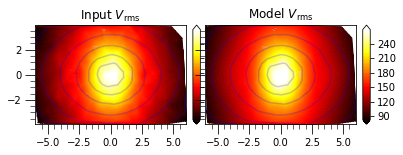

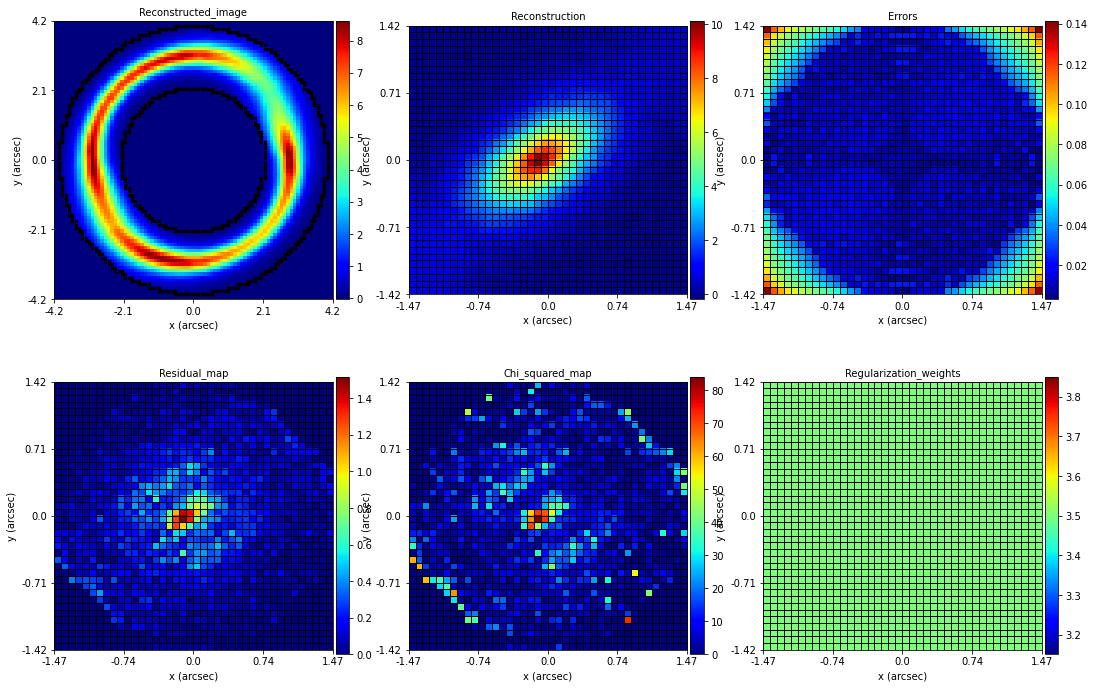

CPU times: user 6.8 s, sys: 99.6 ms, total: 6.89 s
Wall time: 5.1 s


-5074.747828426989

In [14]:
#In order: ML, beta, inc, log_mbh, log_rho_s, qDM, mag_shear, phi_shear, gamma 
ml_model     = np.linspace(ml, 5, surf_lum.size)           #mass to light ratio
beta_model   = beta                                        #anisotropy [ad]
p0           = np.append(ml_model, beta_model)

others = np.array([qinc, np.log10(mbh), kappa_s, qDM, 0.02, 88, 1.0])#Other parameters
p0     = np.append(p0, others)                                       #All parameters

%time model_analytical(p0) 